In [1]:
#Import necessary libraries
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import pandas as pd
import numpy as np
import math
import datetime as dt


#Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

#For DL model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

#Visualization
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import display
from Utilities import plot_series, moving_average_forecast, windowed_dataset
#Suppresses exceptions
from contextlib import suppress

with suppress(FileNotFoundError, PermissionError):
    with open("file.txt", mode="rt") as f:
        print(f.readlines())

2023-11-30 10:50:23.163253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Downloading updated BTC price data from coinranking website using API_request

In [2]:
#%run API_request.ipynb

## Data Exploratory

In [3]:
df = pd.read_csv('BTC-USD.csv') 

In [4]:
df.head(10)

,price,timestamp,Date
0,37852.241065,1701216000,2023-11-29 00:00:00
1,37258.896629,1701129600,2023-11-28 00:00:00
2,37503.352220,1701043200,2023-11-27 00:00:00
3,37841.411426,1700956800,2023-11-26 00:00:00
4,37742.774085,1700870400,2023-11-25 00:00:00
5,37313.108377,1700784000,2023-11-24 00:00:00
6,37454.247016,1700697600,2023-11-23 00:00:00
7,35889.406071,1700611200,2023-11-22 00:00:00
8,37456.727881,1700524800,2023-11-21 00:00:00
9,37416.200329,1700438400,2023-11-20 00:00:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      1821 non-null   float64
 1   timestamp  1827 non-null   int64  
 2   Date       1827 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 42.9+ KB


In [6]:
df.describe()

,price,timestamp
count,1821.000000,1.827000e+03
mean,23843.674141,1.622333e+09
std,16143.744136,4.558065e+07
min,3202.451506,1.543450e+09
25%,9438.536636,1.582891e+09
50%,20848.498437,1.622333e+09
75%,35339.605658,1.661774e+09
max,67566.474801,1.701216e+09


In [7]:
##Check for Nulls
print(f"Total number of Null values: {df.isnull().values.sum()}")

Total number of Null values: 6


In [8]:
#There are only 6 Null values so just drop them
df = df.dropna(axis=0)

# Drop rows where the year is not equal to 2018, because 2018 data only has 2 months data.
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')
df = df[df['Date'].dt.year != 2018]
# Sort the DataFrame by the 'Date' column in ascending order (oldest to latest)
df = df.sort_values(by='Date')
# Reset the index
df = df.reset_index(drop=True)
print(df)

             price   timestamp       Date
0      3713.722842  1546300800 2019-01-01
1      3841.206297  1546387200 2019-01-02
2      3919.393105  1546473600 2019-01-03
3      3807.574265  1546560000 2019-01-04
4      3845.992307  1546646400 2019-01-05
...            ...         ...        ...
1783  37742.774085  1700870400 2023-11-25
1784  37841.411426  1700956800 2023-11-26
1785  37503.352220  1701043200 2023-11-27
1786  37258.896629  1701129600 2023-11-28
1787  37852.241065  1701216000 2023-11-29

[1788 rows x 3 columns]


In [9]:
##Analysis in year 2021
year = 2021

# Filter data for the specified year
df_year = df.loc[(df['Date'].dt.year == year)]

# Group by month and calculate the mean for High and Low
monthly_year = df_year.groupby(df_year['Date'].dt.strftime('%B'))[['price']].mean()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthly_year = monthly_year.reindex(month_order, axis=0)

monthly_year

,price
Date,
January,34699.092932
February,46406.985264
March,54609.042624
April,57597.698670
May,47402.227628
June,35851.147704
July,34184.762526
August,45588.582233
September,46054.270824


## Creating an interactive dashboard to display monthly High and Low of BTC Price from 2014-2022

In [10]:

def plot_dashboard(year):    
    # Filter data for the specified year
    df_year = df.loc[(df['Date'].dt.year == year)]

    # Group by month and calculate the mean for High and Low
    monthly_year = df_year.groupby(df_year['Date'].dt.strftime('%B'))[['price']].mean()
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
    monthly_year = monthly_year.reindex(month_order, axis=0)

    months = monthly_year.index
    price = monthly_year['price']
#    price = monthly_year['High']
#    low = monthly_year['Low']

    bar_width = 0.35
    index = range(len(months))

    high_color = '#FF5733'  # Orange
    low_color = '#33B5E5'   # Blue
    fig, ax = plt.subplots()
    bar1 = ax.bar(index, price, bar_width, label='Price', color=high_color)
#    bar2 = ax.bar([i + bar_width for i in index], low, bar_width, label='Low', color=low_color)

    # Set background color
    ax.set_facecolor('#F5F5F5')  # Light Gray
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Values')
    ax.set_title(f"Monthly Price Averages for {year}")
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(months, rotation=45, ha='right')

    ax.legend()
    plt.show()

# Get unique years from the DataFrame
years = df['Date'].dt.year.unique()

# Create an interactive dropdown for choosing the year
year_dropdown = widgets.Dropdown(options=years, description='Select Year')

# Define the interaction function
def update_plot(year):  
    # Display the interactive plot
    plot_dashboard(year)

# Connect the dropdown to the interaction function
interact(update_plot, year=year_dropdown);


interactive(children=(Dropdown(description='Select Year', options=(2019, 2020, 2021, 2022, 2023), value=2019),…

## Ploting a line time series figure for the Close values from 2014-2022

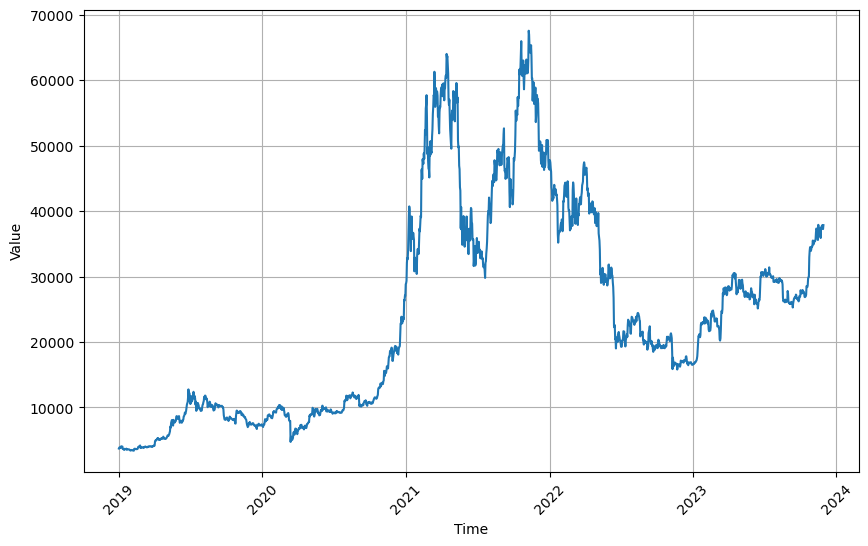

In [11]:
plot_series(df['Date'], df['price'])

## Data preprocessing

### Split the dataset

In [12]:
# Define the split time, using 80% for training, 20% for validating
split_time = int(df.shape[0] * 0.8)

# Get the train set 
time_train = df['Date'][:split_time]
x_train = df['price'][:split_time]

# Get the validation set
time_valid = df['Date'][split_time:]
x_valid = df['price'][split_time:]

print(f"Number of training data points {x_train.shape[0]}")
print(f"Number of validating data points {x_valid.shape[0]}")

Number of training data points 1430
Number of validating data points 358


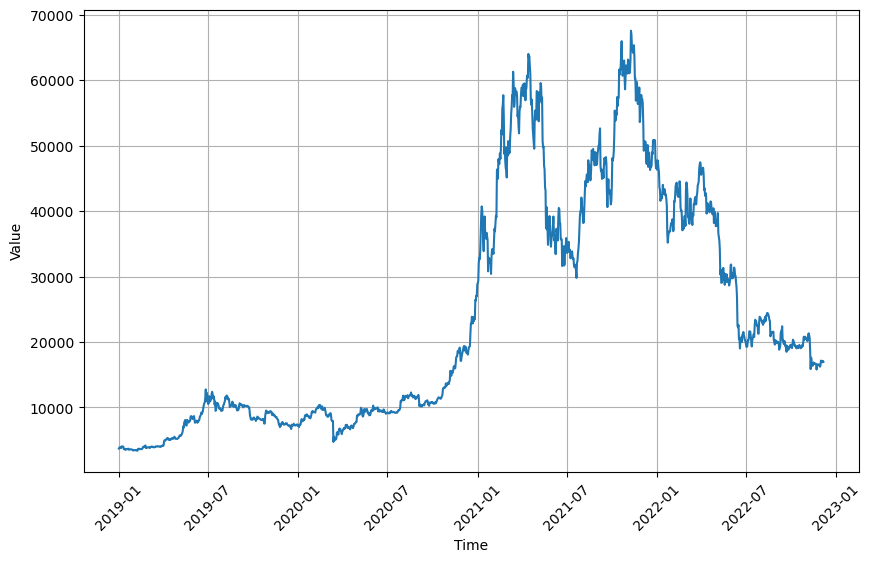

0        3713.722842
1        3841.206297
2        3919.393105
3        3807.574265
4        3845.992307
            ...     
1783    37742.774085
1784    37841.411426
1785    37503.352220
1786    37258.896629
1787    37852.241065
Name: price, Length: 1788, dtype: float64


In [13]:
plot_series(time_train, x_train)
print(df['price'])

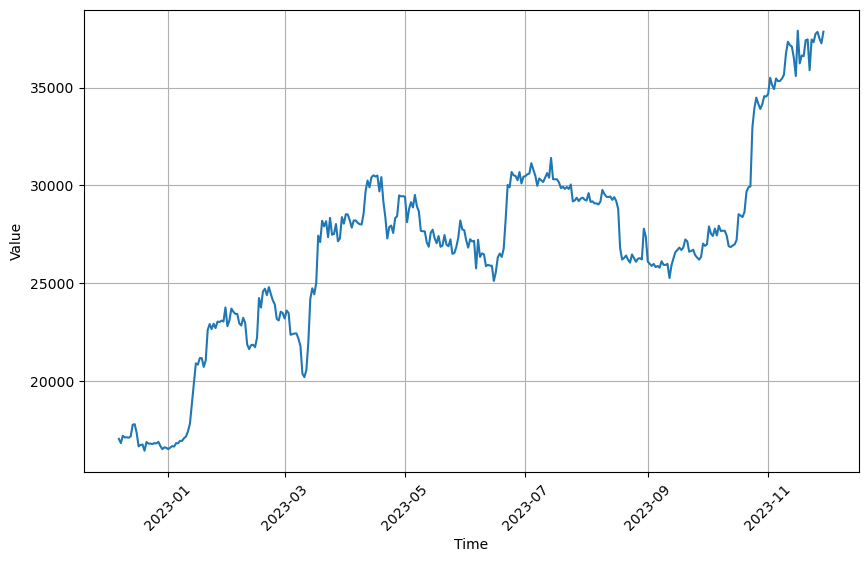

1430    17059.316126
1431    16837.873452
1432    17216.257653
1433    17131.348968
1434    17138.877847
            ...     
1783    37742.774085
1784    37841.411426
1785    37503.352220
1786    37258.896629
1787    37852.241065
Name: price, Length: 358, dtype: float64


In [14]:
# Plot the validation set
plot_series(time_valid, x_valid)
print(x_valid)

## Naive Forecast
First, let's build a baseline performance by doing a naive forecast by simply assuming that the next value will be similar as the previous one

In [15]:
# Naive forecast
naive_forecast = df['price'][split_time - 1:-1]

# Define time step within the valid set
time_step = 100  

# Check the ground truth and prediction at the specified time step
ground_truth_at_time_step = x_valid.iloc[time_step]
prediction_at_time_step = naive_forecast.iloc[time_step + 1]

# Print the results
print(f'Ground truth at time step {time_step}: {ground_truth_at_time_step}')
print(f'Prediction at time step {time_step + 1}: {prediction_at_time_step}')

Ground truth at time step 100: 25024.191152664884
Prediction at time step 101: 25024.191152664884


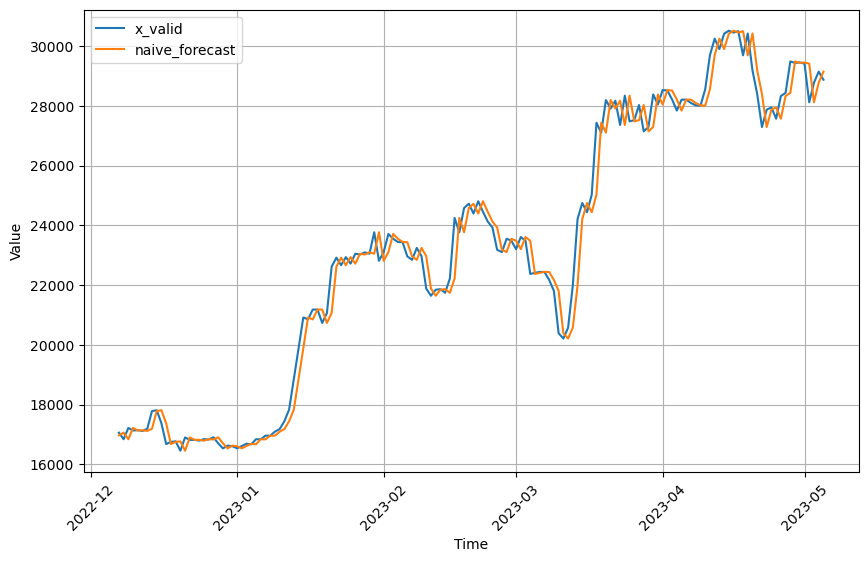

In [16]:
# Plot the results
plot_series(time_valid, (x_valid, naive_forecast), start=0, end=150, legend=('x_valid', 'naive_forecast'))

In [17]:
print("Baseline Perfomance")
print(f"MSE {tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()}")
print(f"MAE {tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()}")

Baseline Perfomance
MSE 349885.37997053633
MAE 390.03703046843935


The values above will be our baseline and we will see if other advanced methods can outperform naive forecasting.

## Moving Average

Now let's apply a moving average technique. This sums up a series of time steps and the average will be the prediction for the next time step. For example, the average of the measurements at time steps 1 to 10 will be the forecast for time step 11, then the average for time steps 2 to 11 will be the forecast for time step 12, and so on.

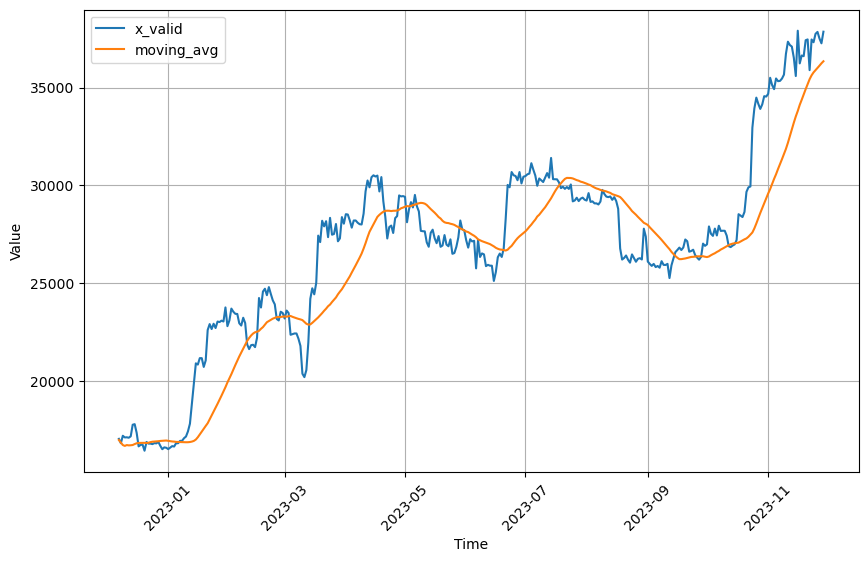

In [18]:
# Generate the moving average forecast
moving_avg = moving_average_forecast(df['price'], 30)[split_time - 30:]

# Plot the results
plot_series(time_valid, (x_valid, moving_avg), legend=('x_valid', 'moving_avg'))

In [19]:
print("Moving Average Perfomance")
print(f"MSE {tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()}")
print(f"MAE {tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()}")

Moving Average Perfomance
MSE 4744200.516385585
MAE 1630.3934334383155


As we can notice, Moving Average is actually worse than Naive Forecasting. The reason might be due to the inability of not capturing the trend or seasonality. In particular, those huge spikes during the FOMO events cause big deviations as shown in the plot above. With that, let's continue to explore the seasonal decomposition of time series (STL).

## Seasonal decomposition of time series (STL)

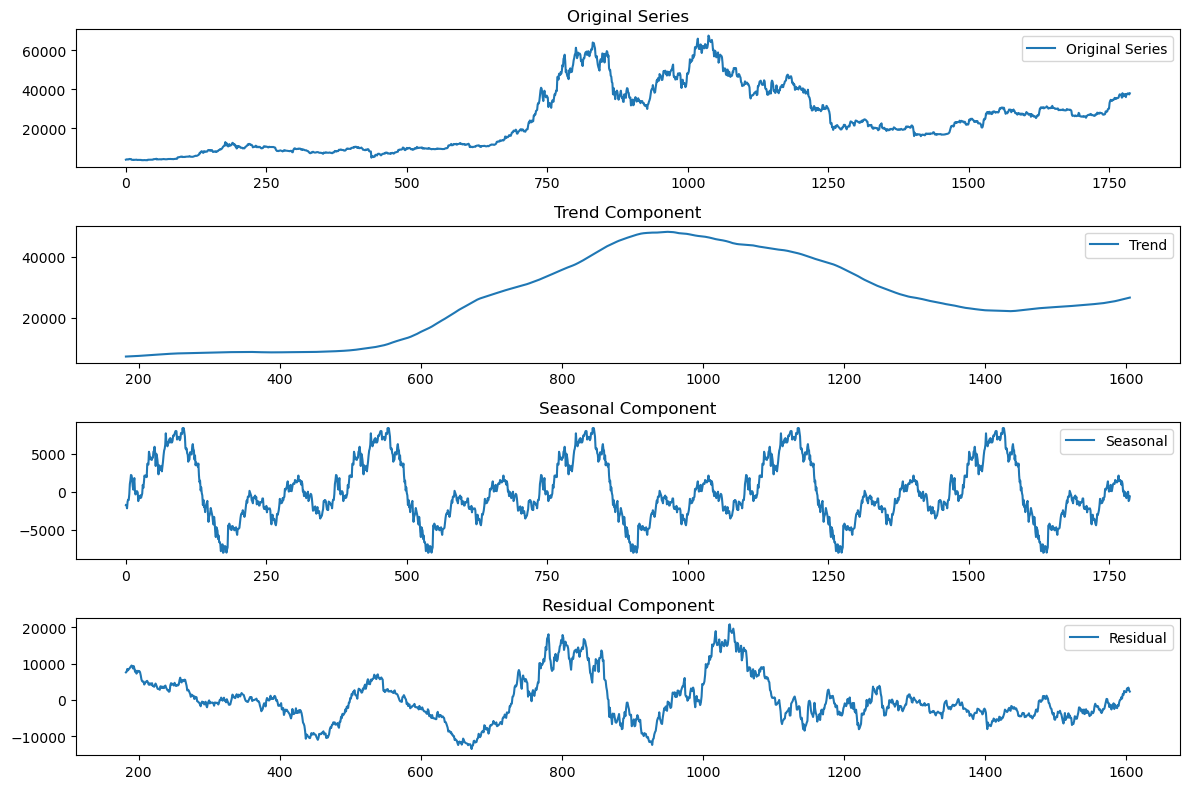

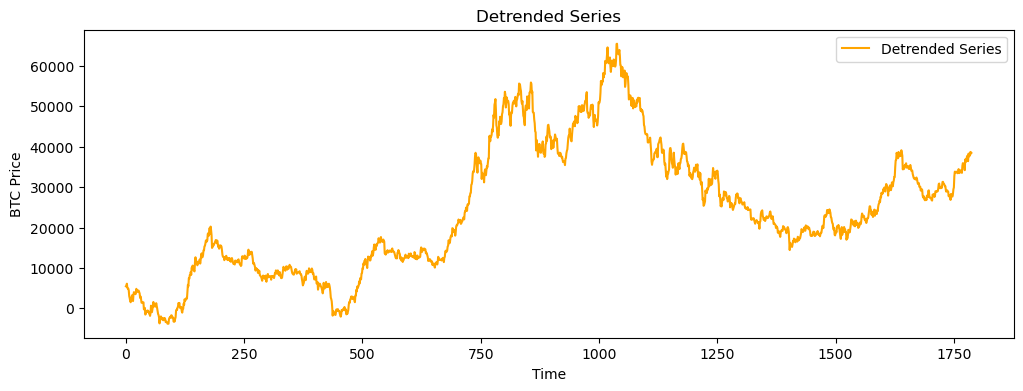

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(df['price'], model='additive', period=365)  # Assuming 3 years seasonality

# Access the trend, seasonal, and residual components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Subtract the seasonal component to remove seasonality
detrended_series = df['price'] - seasonal

# Plot the original and decomposed components for visualization
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df['price'], label='Original Series')
plt.legend()
plt.title('Original Series')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend()
plt.title('Residual Component')

plt.tight_layout()
plt.show()

# Plot the detrended series separately
plt.figure(figsize=(12, 4))
plt.plot(detrended_series, label='Detrended Series', color='orange')
plt.legend()
plt.title('Detrended Series')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.show()


It appears that with a limited data of BTC price, it's extremely challenging to detect and remove seasonality from the origional series effectively. Now let's try deep learning models to see if they can beat the baseline performance.

## Building a Deep Neural Network

### Prepare Features and Labels

In [49]:
# Parameters
#Group consecutive elements of the data and use that to predict a future value.  Here, we will take 30 elements per window (i.e. size parameter) and you will move this window 1 element at a time
window_size = 30
batch_size = 64
shuffle_buffer_size = 2000 #should put a number equal or greater than the total number of elements for better shuffling.

In [22]:
print(windowed_dataset.__doc__)

Generates dataset window
    
    Args:
        series (array of float): contains the values of the series
        window_size (int): the number of time steps to average
        batch_size (int): the batch size
        shuffle_buffer (int): buffer size to use for the shuffle method
        
    Returns:
        dataset (TF format): TF Dataset contains time windows
    


### Normalizing Data

In [23]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

x_train = np.array(x_train)
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
x_train_normalized = scaler.fit_transform(x_train.reshape(-1, 1)).flatten()

In [24]:
# Generate the dataset windows
dataset = windowed_dataset(x_train_normalized, window_size, batch_size, shuffle_buffer_size)

# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (64, 30)
shape of label: (64,)


### Learning Rate Sensitivity 

In [25]:
# Build a DNN model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape=[window_size], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])

model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1984      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6209 (24.25 KB)
Trainable params: 6209 (24.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=200, callbacks=[lr_schedule])

Epoch 1/200
22/22 [==============================] - 1s 8ms/step - loss: 1.1240 - lr: 1.0000e-08
Epoch 2/200
22/22 [==============================] - 0s 3ms/step - loss: 1.1240 - lr: 1.1220e-08
Epoch 3/200
22/22 [==============================] - 0s 3ms/step - loss: 1.1240 - lr: 1.2589e-08
Epoch 4/200
22/22 [==============================] - 0s 3ms/step - loss: 1.1240 - lr: 1.4125e-08
Epoch 5/200
22/22 [==============================] - 0s 2ms/step - loss: 1.1239 - lr: 1.5849e-08
Epoch 6/200
22/22 [==============================] - 0s 3ms/step - loss: 1.1239 - lr: 1.7783e-08
Epoch 7/200
22/22 [==============================] - 0s 3ms/step - loss: 1.1239 - lr: 1.9953e-08
Epoch 8/200
22/22 [==============================] - 0s 2ms/step - loss: 1.1239 - lr: 2.2387e-08
Epoch 9/200
22/22 [==============================] - 0s 3ms/step - loss: 1.1239 - lr: 2.5119e-08
Epoch 10/200
22/22 [==============================] - 0s 2ms/step - loss: 1.1239 - lr: 2.8184e-08
Epoch 11/200
22/22 [=========

### Visualize the results and pick an optimal learning rate.

(1e-06, 0.1, 0.0, 3.0)

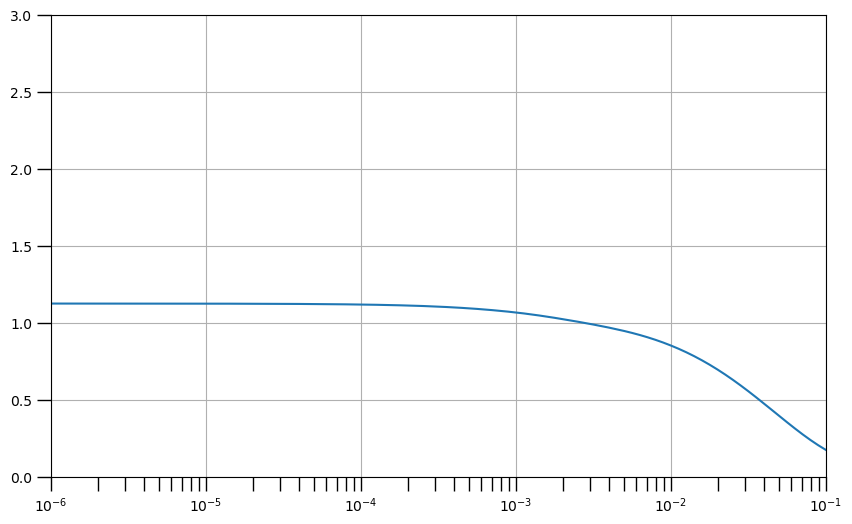

In [27]:
# Define the learning rate array
lrs = 1e-6 * (10 ** (np.arange(200) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-6, 1e-1, 0, 3])

Learning rate of approximately 1e-4 look stable so let's choose that for our below DL models

### Creating a Callback class


In [50]:
#Define a callback class in case you want to finish the model training sooner
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when the loss falls below 0.4

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the loss
    if(logs.get('loss') < 0.02):

      # Stop if threshold is met
      print("\nLoss is lower than 0.001 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

### Build the DNN Model

In [29]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build DNN model
model_nn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, input_shape=[window_size], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])

model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 73985 (289.00 KB)
Trainable params: 73985 (289.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train the model

In [30]:
# Set the learning rate
learning_rate = 5e-4

model_nn.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


In [31]:
history = model_nn.fit(dataset, epochs=300)

Epoch 1/300
22/22 [==============================] - 1s 5ms/step - loss: 2.8851
Epoch 2/300
22/22 [==============================] - 0s 4ms/step - loss: 2.2452
Epoch 3/300
22/22 [==============================] - 0s 4ms/step - loss: 1.7774
Epoch 4/300
22/22 [==============================] - 0s 4ms/step - loss: 1.4179
Epoch 5/300
22/22 [==============================] - 0s 4ms/step - loss: 1.1416
Epoch 6/300
22/22 [==============================] - 0s 4ms/step - loss: 0.9314
Epoch 7/300
22/22 [==============================] - 0s 4ms/step - loss: 0.7697
Epoch 8/300
22/22 [==============================] - 0s 4ms/step - loss: 0.6411
Epoch 9/300
22/22 [==============================] - 0s 4ms/step - loss: 0.5456
Epoch 10/300
22/22 [==============================] - 0s 4ms/step - loss: 0.4684
Epoch 11/300
22/22 [==============================] - 0s 4ms/step - loss: 0.4100
Epoch 12/300
22/22 [==============================] - 0s 3ms/step - loss: 0.3609
Epoch 13/300
22/22 [=================

### Plot the loss


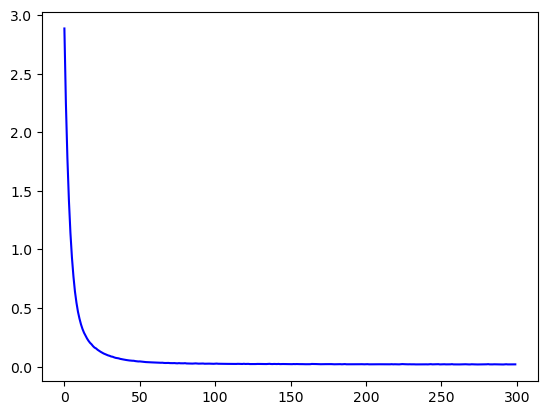

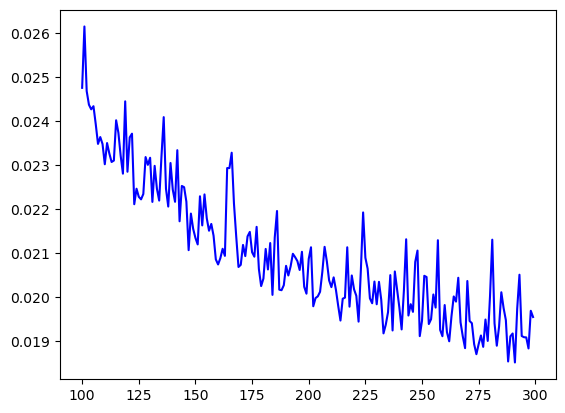

In [32]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

# Plot all but the first 200
loss = history.history['loss']
epochs = range(100, len(loss))
plot_loss = loss[100:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

As you can see, the model is still learning after the first 100 epoches

### Model Prediction
Using a Window of 30 days to predict the value of the next day

In [33]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = df['price'][split_time - window_size:].values
forecast_series = np.array(forecast_series)
forecast_series_normalized = scaler.fit_transform(forecast_series.reshape(-1, 1)).flatten()
print(forecast_series.shape)

for time in range(len(forecast_series) - window_size):
    input_window = forecast_series_normalized[time:time + window_size][np.newaxis, :]
    prediction = model_nn.predict(input_window)
    forecast.append(scaler.inverse_transform(prediction.reshape(1, -1)))


# Convert to a numpy array and drop single-dimensional axes
results = np.array(forecast).squeeze()

# Display the results
print(results)


(388,)
1/1 [==============================] - 0s 13ms/step
[16754.941 16876.377 16879.75  17053.334 17048.082 17096.654 17103.271
 17145.941 17437.922 17590.293 17459.496 17074.062 16895.652 16806.707
 16623.49  16747.45  16761.066 16770.012 16767.902 16800.51  16819.35
 16875.488 16777.494 16635.86  16595.654 16587.35  16550.559 16568.469
 16620.732 16650.373 16733.041 16776.078 16867.387 16913.7   16983.47
 17054.271 17197.176 17453.98  18110.21  18983.89  19946.082 20433.877
 20842.592 21044.041 20910.115 20985.3   21753.596 22302.934 22489.309
 22711.86  22742.434 22897.428 22938.227 22986.307 23007.824 23342.53
 23058.875 23048.574 23343.28  23434.277 23429.863 23418.56  23228.643
 23094.234 23186.639 23099.803 22538.889 22052.03  21868.322 21798.207
 21723.875 21948.86  23072.232 23416.564 23928.56  24291.734 24327.756
 24540.154 24466.879 24261.984 24072.148 23617.49  23311.873 23363.656
 23369.537 23262.648 23327.107 23297.066 22773.557 22474.258 22331.223
 22264.213 22099.004 

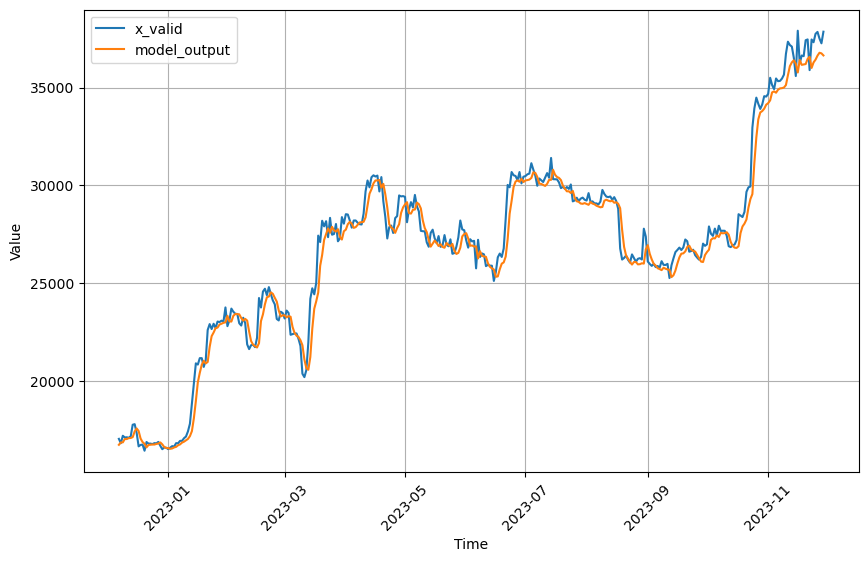

In [34]:
# Plot the results
plot_series(time_valid, (x_valid, results), legend=('x_valid', 'model_output'))

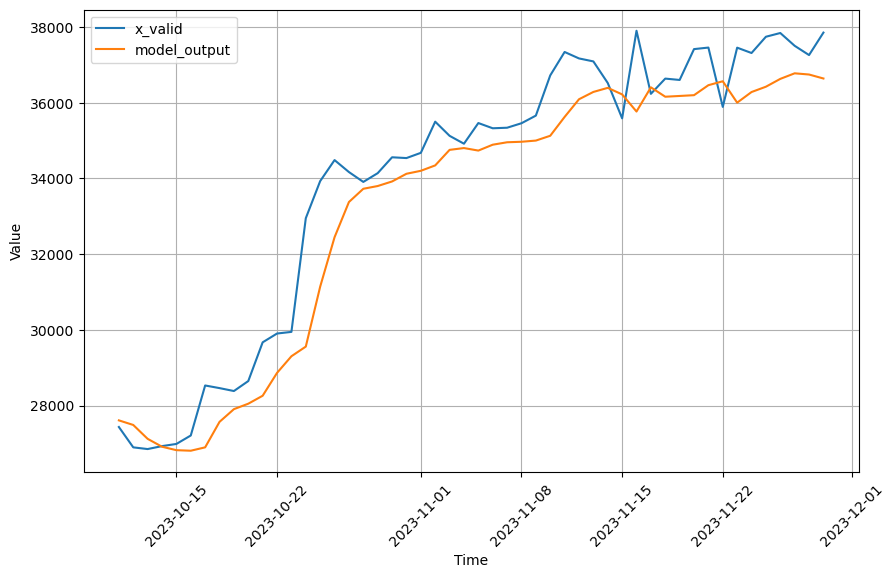

In [35]:
#Zoom in
# Choose the most recent 50 values
recent_length = 50
x_valid_recent = x_valid.iloc[-recent_length:]
results_recent = results[-recent_length:]
time_valid_recent = time_valid.iloc[-recent_length:]

# Plot the most recent 50 values
plot_series(time_valid_recent, (x_valid_recent, results_recent), legend=('x_valid', 'model_output'))


In [36]:
# Compute the metrics
print(f"MSE: {tf.keras.metrics.mean_squared_error(x_valid, results).numpy()}")
print(f"MAE: {tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()}")

MSE: 561293.3125
MAE: 516.9994506835938


## Building a Simple RNN

### Train the Model

In [37]:

# Reset states generated by Keras
tf.keras.backend.clear_session()

model_rnn = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(256, return_sequences=True, activation="relu"), 
  tf.keras.layers.SimpleRNN(256, activation="relu"),
  tf.keras.layers.Dense(1),
])
# Set the learning rate
learning_rate = 1e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model_rnn.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model_rnn.fit(dataset, epochs=300)

Epoch 1/300
22/22 [==============================] - 3s 54ms/step - loss: 0.0856 - mae: 0.3132
Epoch 2/300
22/22 [==============================] - 1s 51ms/step - loss: 0.0713 - mae: 0.2843
Epoch 3/300
22/22 [==============================] - 1s 52ms/step - loss: 0.0587 - mae: 0.2562
Epoch 4/300
22/22 [==============================] - 1s 52ms/step - loss: 0.0463 - mae: 0.2250
Epoch 5/300
22/22 [==============================] - 1s 51ms/step - loss: 0.0326 - mae: 0.1859
Epoch 6/300
22/22 [==============================] - 1s 52ms/step - loss: 0.0176 - mae: 0.1312
Epoch 7/300
22/22 [==============================] - 1s 52ms/step - loss: 0.0061 - mae: 0.0734
Epoch 8/300
22/22 [==============================] - 1s 52ms/step - loss: 0.0013 - mae: 0.0375
Epoch 9/300
22/22 [==============================] - 1s 51ms/step - loss: 7.4187e-04 - mae: 0.0320
Epoch 10/300
22/22 [==============================] - 1s 54ms/step - loss: 6.4227e-04 - mae: 0.0285
Epoch 11/300
22/22 [=====================

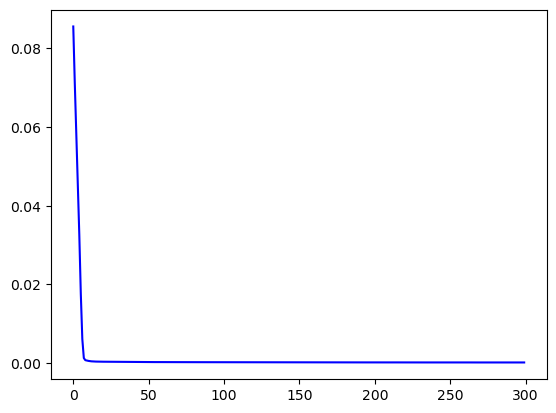

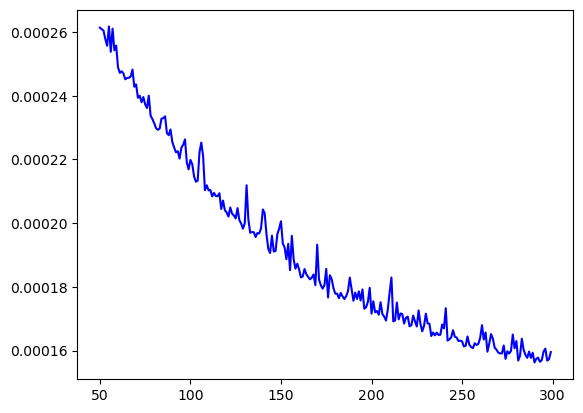

In [38]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

# Plot all but the first 200
loss = history.history['loss']
epochs = range(50, len(loss))
plot_loss = loss[50:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [39]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = df['price'][split_time - window_size:].values
forecast_series = np.array(forecast_series)
forecast_series_normalized = scaler.fit_transform(forecast_series.reshape(-1, 1)).flatten()
print(forecast_series.shape)

for time in range(len(forecast_series) - window_size):
    input_window = forecast_series_normalized[time:time + window_size][np.newaxis, :]
    prediction = model_rnn.predict(input_window)
    forecast.append(scaler.inverse_transform(prediction.reshape(1, -1)))


# Convert to a numpy array and drop single-dimensional axes
results_rnn = np.array(forecast).squeeze()


(388,)
1/1 [==============================] - 0s 17ms/step


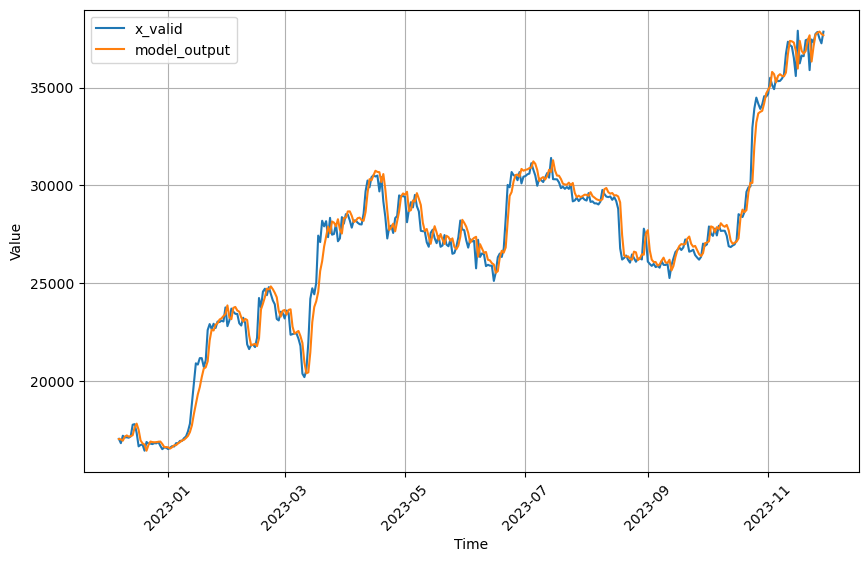

In [40]:
# Plot the results
plot_series(time_valid, (x_valid, results_rnn), legend=('x_valid', 'model_output'))

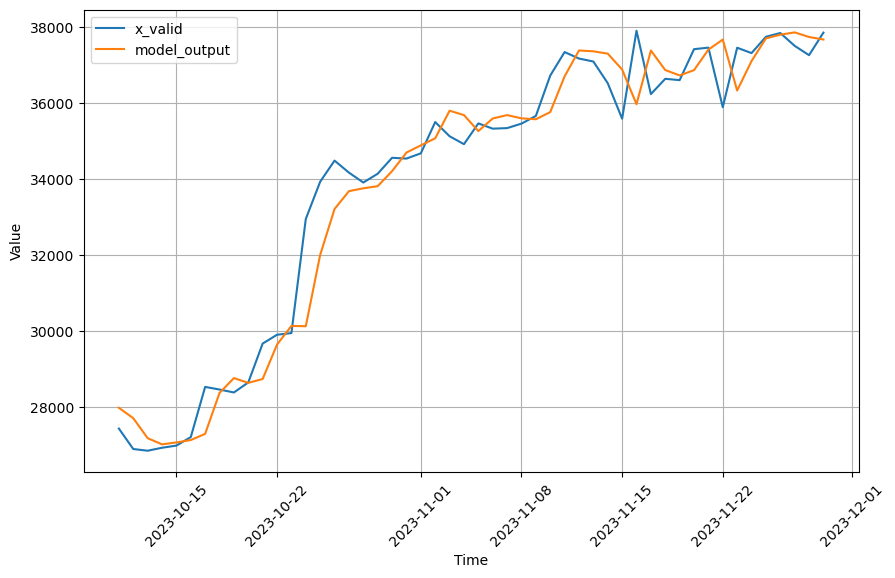

In [41]:
#Zoom in
# Choose the most recent 50 values
recent_length = 50
x_valid_recent = x_valid.iloc[-recent_length:]
results_recent = results_rnn[-recent_length:]
time_valid_recent = time_valid.iloc[-recent_length:]

# Plot the most recent 50 values
plot_series(time_valid_recent, (x_valid_recent, results_recent), legend=('x_valid', 'model_output'))

In [42]:
# Compute the metrics
print(f"MSE: {tf.keras.metrics.mean_squared_error(x_valid, results_rnn).numpy()}")
print(f"MAE: {tf.keras.metrics.mean_absolute_error(x_valid, results_rnn).numpy()}")

MSE: 460888.90625
MAE: 466.3591003417969


### Building LSTM

In [43]:


# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model_lstm = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
#  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))),
  tf.keras.layers.LSTM(256, activation="relu", return_sequences=True),
  tf.keras.layers.LSTM(256, activation="relu"),
  tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-4

# Set the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model_lstm.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model_lstm.fit(dataset, epochs=300)

Epoch 1/300
22/22 [==============================] - 5s 121ms/step - loss: 0.0662 - mae: 0.2704
Epoch 2/300
22/22 [==============================] - 3s 117ms/step - loss: 0.0192 - mae: 0.1301
Epoch 3/300
22/22 [==============================] - 3s 123ms/step - loss: 0.0033 - mae: 0.0643
Epoch 4/300
22/22 [==============================] - 3s 110ms/step - loss: 0.0016 - mae: 0.0412
Epoch 5/300
22/22 [==============================] - 3s 113ms/step - loss: 0.0014 - mae: 0.0326
Epoch 6/300
22/22 [==============================] - 3s 110ms/step - loss: 0.0013 - mae: 0.0310
Epoch 7/300
22/22 [==============================] - 3s 113ms/step - loss: 0.0012 - mae: 0.0304
Epoch 8/300
22/22 [==============================] - 3s 114ms/step - loss: 0.0011 - mae: 0.0291
Epoch 9/300
22/22 [==============================] - 3s 121ms/step - loss: 0.0011 - mae: 0.0281
Epoch 10/300
22/22 [==============================] - 3s 120ms/step - loss: 0.0010 - mae: 0.0271
Epoch 11/300
22/22 [===================

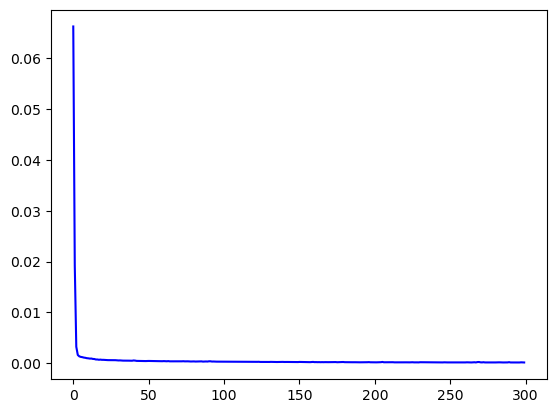

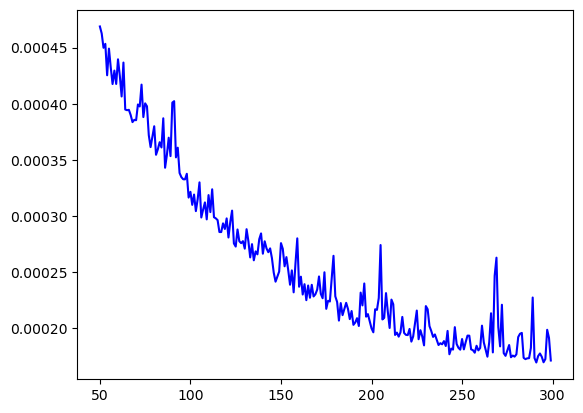

In [44]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

# Plot all but the first 200
loss = history.history['loss']
epochs = range(50, len(loss))
plot_loss = loss[50:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

### Model Prediction

In [45]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = df['price'][split_time - window_size:].values
forecast_series = np.array(forecast_series)
forecast_series_normalized = scaler.fit_transform(forecast_series.reshape(-1, 1)).flatten()
print(forecast_series.shape)

for time in range(len(forecast_series) - window_size):
    input_window = forecast_series_normalized[time:time + window_size][np.newaxis, :]
    prediction = model_lstm.predict(input_window)
    forecast.append(scaler.inverse_transform(prediction.reshape(1, -1)))


# Convert to a numpy array and drop single-dimensional axes
results_lstm = np.array(forecast).squeeze()


(388,)
1/1 [==============================] - 0s 19ms/step


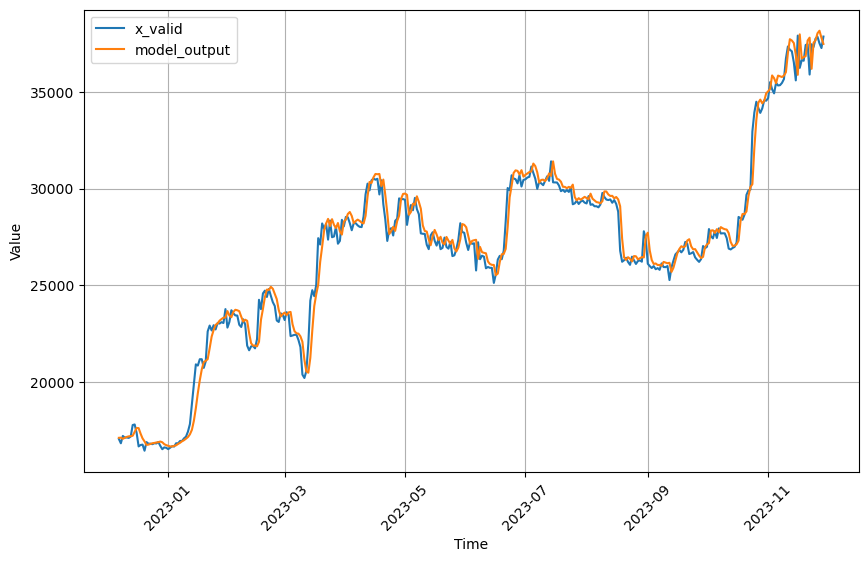

In [46]:
# Plot the results

plot_series(time_valid, (x_valid, results_lstm), legend=('x_valid', 'model_output'))

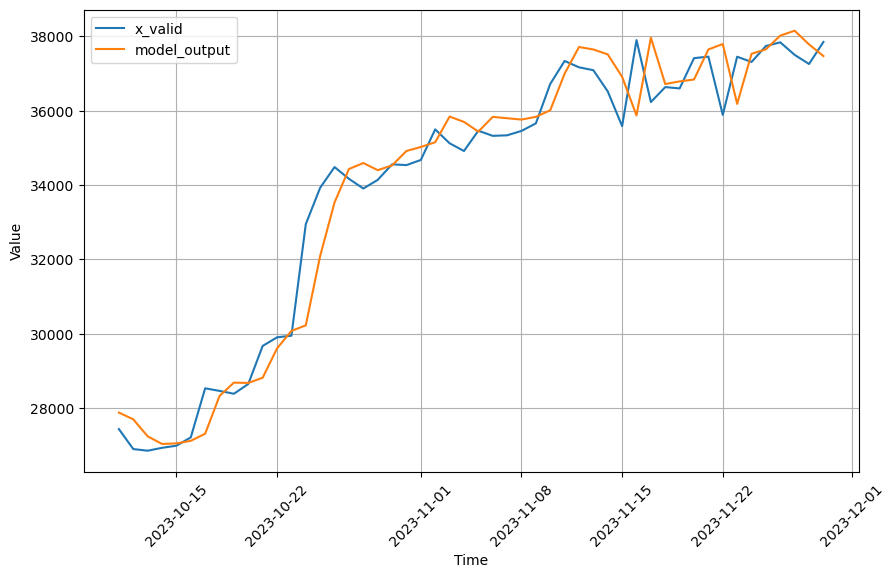

In [47]:
#Zoom in
# Choose the most recent 50 values
recent_length = 50
x_valid_recent = x_valid.iloc[-recent_length:]
results_recent = results_lstm[-recent_length:]
time_valid_recent = time_valid.iloc[-recent_length:]

# Plot the most recent 200 values
plot_series(time_valid_recent, (x_valid_recent, results_recent), legend=('x_valid', 'model_output'))

In [48]:
# Compute the metrics
print(f"MSE: {tf.keras.metrics.mean_squared_error(x_valid, results_lstm).numpy()}")
print(f"MAE: {tf.keras.metrics.mean_absolute_error(x_valid, results_lstm).numpy()}")

MSE: 462933.40625
MAE: 473.86370849609375


### In summary:
- LSTM and RNN demonstrate better performance compared to DNN.
- Overall, deep learning outperforms Moving Average.
- Deep Learning is compatible with Naive Forecast; this compatibility may be attributed to the limited data on BTC prices, given that BTC emerged as a relatively new technology and became widely available for public trading after 2018.